# Training on 13,231 events from ACTS. Testing on 3308 events from ACTS.

In [ ]:
!nvidia-smi

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
import sys
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0E:00.0)


### Load in the data.

In [3]:
%%time
modelpath = "data/models/ACTS-10N-25T-260R.h5"
filepath  = "data/sets/ACTS-10N-25T-16539E-260R.gz"
frame     = pd.read_csv(filepath)
events    = [event for (_, event) in frame.groupby("event_id", sort=False)]
percent   = 0.8
cutoff    = int(percent * len(events))
train, test = events[:cutoff], events[cutoff:]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
print("Train takes up {} bytes.".format(sys.getsizeof(train)))
print("Test takes up {} bytes.".format(sys.getsizeof(test)))
if (not utils.is_prepared(train[0])) or (not utils.is_prepared(test[0])):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")
else:
    del frame  
    del events  # To save on memory.

Train is list of 13232 events.
Test is list of 3308 events.
Train takes up 105920 bytes.
Test takes up 26528 bytes.
CPU times: user 6.84 s, sys: 1.29 s, total: 8.13 s
Wall time: 8.12 s


In [4]:
order = ["phi", "r", "z"]

### Get an idea for how the tracks are distributed among the events.

In [ ]:
dist = metrics.distributions(pd.concat(train))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

In [ ]:
dist = metrics.distributions(pd.concat(test))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

### Show an example of the data.

In [ ]:
n = np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="zr", title="Train {}".format(n))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [ ]:
visuals.display(train[n], order)

### Create the model.

In [5]:
input_shape  = (260, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [6]:
model = keras.models.load_model(modelpath)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [ ]:
model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

### Fit the model.

In [ ]:
%%time
# 128 + 32
epochs     = 128
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
        keras.callbacks.EarlyStopping(patience=10, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)]))

### Alter noise.

In [29]:
visuals.display(frame, order)

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-2.788292,32.0,-28.526600,1,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-2.779026,72.0,-32.384400,1,,,,,,,,,,,,,,,,,,,,,,,,,,
2,-2.769308,117.0,-36.603100,1,,,,,,,,,,,,,,,,,,,,,,,,,,
3,-2.765711,72.0,340.865000,,1,,,,,,,,,,,,,,,,,,,,,,,,,
4,-2.760917,32.0,171.906000,,1,,,,,,,,,,,,,,,,,,,,,,,,,
5,-2.756552,172.0,-42.059400,1,,,,,,,,,,,,,,,,,,,,,,,,,,
6,-2.736767,260.0,-55.000000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
7,-2.713623,360.0,-55.000000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
8,-2.681870,500.0,-79.000000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.644604,660.0,-91.000000,1,,,,,,,,,,,,,,,,,,,,,,,,,,


In [25]:
frame = test[300].copy()
guess = model.predict(ext.extract_input([frame], order))[0]
print(metrics.percent_of_hits_assigned_correctly([frame], guesses=[guess], order=order))
print(np.sort(pd.unique(frame["r"])))

0.972413793103
[   32.    72.   117.   172.   260.   360.   500.   660.   820.  1020.
    nan]


0.972413793103


<IPython.core.display.Javascript object>


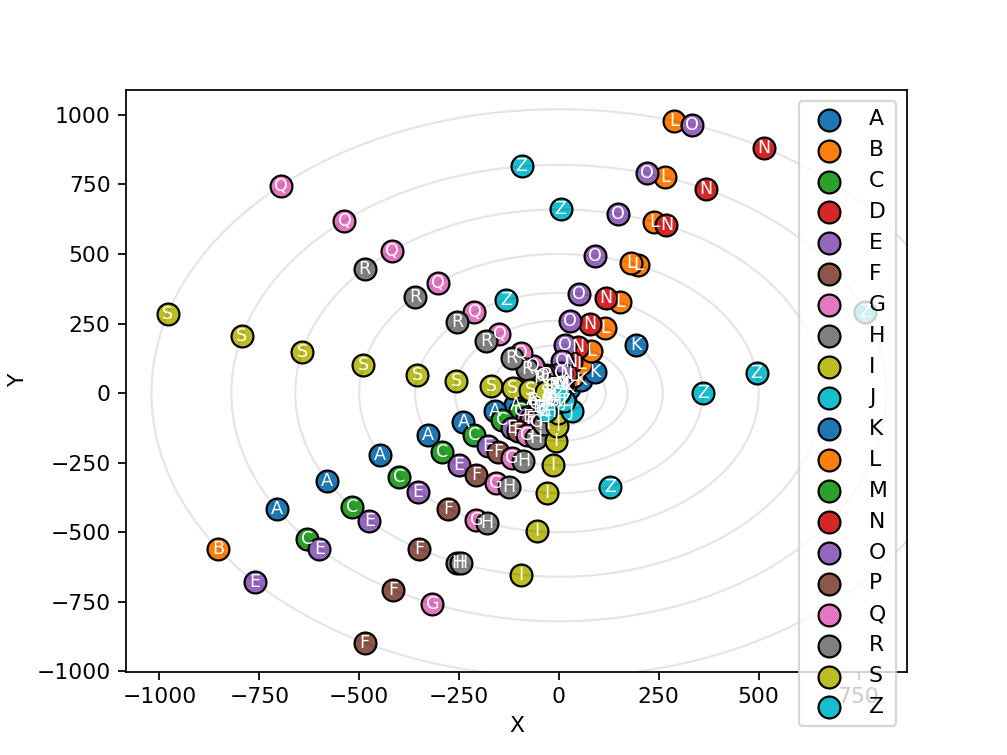

In [33]:
frame.loc[3518579, "phi"] = 0.73
frame.loc[3518579, "r"] = 360
frame.loc[3518579, "z"] = 872
guess = model.predict(ext.extract_input([frame], order))[0]
print(metrics.percent_of_hits_assigned_correctly([frame], guesses=[guess], order=order))
visuals.Plot2D(frame, order, guess).plot(mode="xy")
#visuals.Plot2D(frame, order, guess).plot(mode="zr")

### Display information about the model after fitting it.

In [ ]:
%%time
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
tracks_correct75 = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=.75)
tracks_correct50 = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=.50)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly (100%): {}%".format(tracks_correct * 100))
print("Percent of tracks assigned correctly (75%) : {}%".format(tracks_correct75 * 100))
print("Percent of tracks assigned correctly (50%) : {}%".format(tracks_correct50 * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

### Display how one of the model's predictions looks.

In [ ]:
n  = 3138  # np.random.randint(len(test))
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="zr", title="Prediction {}".format(n))
_ = visuals.Plot2D(test[n], order).plot(mode="zr", title="Answer {}".format(n))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy", title="Prediction {}".format(n))
_ = visuals.Plot2D(test[n], order).plot(mode="xy", title="Answer {}".format(n))

In [ ]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

In [ ]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Discrete Accuracy", xticks=list(r))

In [ ]:
%%time
for percent in [0.3, 0.5, 0.75, 1.0]:
    c_tracks = [metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order, percent=percent)
                for n in range(len(guesses))]
    boxes = [[] for _ in r]
    for i in range(len(c_tracks)):
        index = metrics.number_of_tracks(test[i]) - 1
        boxes[index].append(c_tracks[i])
    visuals.boxplot(
        boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks",
        "Percent of Tracks Correctly Assigned ({})".format(percent), xticks=list(r))

In [ ]:
%%time
thresholds = [i / 10 for i in range(11)]
threshold_metrics = [[metrics.threshold_metrics(test[i], guesses[i], n, order)
                      for i in range(len(guesses))] for n in thresholds]
boxes_correct   = [[m[0] for m in metric] for metric in threshold_metrics]
boxes_incorrect = [[m[1] for m in metric] for metric in threshold_metrics]
boxes_multi     = [[m[2] for m in metric] for metric in threshold_metrics]
boxes_none      = [[m[3] for m in metric] for metric in threshold_metrics]
visuals.boxplot(
    boxes_correct, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to correct track]", xticks=thresholds)
visuals.boxplot(
    boxes_incorrect, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to an incorrect track]", xticks=thresholds)
visuals.boxplot(
    boxes_multi, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to multiple tracks]", xticks=thresholds)
visuals.boxplot(
    boxes_none, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to no tracks]", xticks=thresholds)